In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

****
# Import Datasets
****

In [5]:
data_path = "/store/kruu/eye_tracking"
files_list = os.listdir(data_path)
path_list = [os.path.join(data_path, file) for file in files_list]

In [6]:
# Read the tsv file and return the dataframe
def read_tsv(path):
    df = pd.read_csv(path,sep='\t')
    expected_tasks = [f"Task {i}" for i in range(1, 7)]
    expected_tasks = expected_tasks + [f"Task {i} end" for i in range(1, 7)]
    task_counts = df['Event'].value_counts()
    for task in expected_tasks:
        if task not in task_counts or task_counts[task] != 6:
            # raise ValueError(f"Mislabeling detected: '{task}' has {task_counts.get(task, 0)} occurrences instead of 6.")
            print(f"Mislabeling detected for file {path}: '{task}' has {task_counts.get(task, 0)} occurrences instead of 6.")
    return df

In [7]:
all_files = []
for i in range(len(path_list)):
    file = read_tsv(path_list[i])
    all_files.append(file)


/tmp/ipykernel_1866698/2691225492.py:3: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep='\t')
/tmp/ipykernel_1866698/2691225492.py:3: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep='\t')


In [12]:
all_files[0].columns

Index(['Recording timestamp', 'Computer timestamp', 'Sensor', 'Project name',
       'Export date', 'Participant name', 'Recording name', 'Recording date',
       'Recording date UTC', 'Recording start time',
       'Recording start time UTC', 'Recording duration', 'Timeline name',
       'Recording Fixation filter name', 'Recording software version',
       'Recording resolution height', 'Recording resolution width',
       'Recording monitor latency', 'Average calibration accuracy (mm)',
       'Average calibration precision SD (mm)',
       'Average calibration precision RMS (mm)',
       'Average calibration accuracy (degrees)',
       'Average calibration precision SD (degrees)',
       'Average calibration precision RMS (degrees)',
       'Average calibration accuracy (pixels)',
       'Average calibration precision SD (pixels)',
       'Average calibration precision RMS (pixels)',
       'Average validation accuracy (mm)',
       'Average validation precision SD (mm)',
       'A

In [23]:
all_files[0]["Eye movement type"].value_counts()

Eye movement type
Fixation        113822
EyesNotFound     62049
Name: count, dtype: int64

In [30]:
all_files[0]["Eye openness left"]

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
175868    8.421
175869    8.527
175870    8.545
175871    8.474
175872      NaN
Name: Eye openness left, Length: 175873, dtype: float64

In [31]:
all_files[0]["Validity left"]

0             NaN
1         Invalid
2         Invalid
3         Invalid
4         Invalid
           ...   
175868      Valid
175869      Valid
175870      Valid
175871      Valid
175872        NaN
Name: Validity left, Length: 175873, dtype: object

****
# Task range identification
****

In [5]:
# The frequency of recording is 120Hz, that's why consecutive timestamps are at least 8.33ms apart
(all_files[0]["Recording timestamp"].diff()/1e6).value_counts()

Recording timestamp
0.008333    63233
0.008334    30942
0.008332     9322
0.008331     2465
0.008335     1571
            ...  
0.097263        1
0.004968        1
0.003702        1
0.001992        1
0.164029        1
Name: count, Length: 8369, dtype: int64

In [6]:
# The unit of the timestamp is in microsecond
#Duration of the screen recording in minutes
print(f"Duration of screen recording in min: {(all_files[0].query('Event == "ScreenRecordingEnd"')['Recording timestamp'].values - all_files[0].query('Event == "ScreenRecordingStart"')['Recording timestamp'].values).item()/(1e6 * 60)}")

#Total duration of the recording in minutes (unit of the columns, miliseconds)
print(f"Total duration in min: {all_files[0]["Recording duration"].unique().item()/(1000*60)}")

Duration of screen recording in min: 18.937161516666666
Total duration in min: 20.649416666666667


In [7]:
def task_range_finder(db, tasks_arr):
    
    event_df = db.loc[db['Event'].str.contains('Task', na=False)][["Event","Recording timestamp"]]
    event_df = event_df.sort_values(by="Recording timestamp").reset_index(drop=True)
    
    task_ranges = {task: [] for task in tasks_arr}
    task_stack = {}

    for _, row in event_df.iterrows():
        event, timestamp = row["Event"], row["Recording timestamp"]
        
        if "Task" in event and "end" not in event:  # Task Start
            task_type = event
            task_stack[task_type] = timestamp  # Store start time

        elif "end" in event:  # Task End
            task_type = event.replace(" end", "")  # Get task type
            if task_type in task_stack:  # Ensure matching start exists
                start_time = task_stack.pop(task_type)  # Retrieve start time
                task_ranges[task_type].append((start_time, timestamp))

    return task_ranges

In [8]:
# Average task duration per person in seconds
tasks = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6']
durations = {task: [] for task in tasks}
for file in all_files:
        tasks_ranges = task_range_finder(file, tasks)
        for task in tasks_ranges:
                durations[task].append(round(np.std([x[1] - x[0] for x in tasks_ranges[task]]).item()/(1e6),2))
durations

{'Task 1': [10.06, 15.65, 10.22, 6.15, 5.46],
 'Task 2': [4.21, 7.14, 4.77, 3.59, 2.64],
 'Task 3': [2.9, 2.46, 1.71, 2.27, 2.27],
 'Task 4': [7.59, 3.1, 3.31, 3.06, 4.31],
 'Task 5': [4.51, 14.59, 4.08, 7.06, 1.44],
 'Task 6': [3.82, 7.23, 4.58, 1.8, 5.17]}

****
# Data Extraction
****


## Extraction of mouse and gaze + forward fill and backward fill

In [9]:
# Get the gaze point and mouse position data
def feature_extraction(df, tasks, features):
    data = []
    tasks_ranges = task_range_finder(df, tasks)
    for task in tasks_ranges:
        for i, period in enumerate(tasks_ranges[task]):
            data_per_task = df.query(f"`Recording timestamp` >= {period[0]} and `Recording timestamp` <= {period[1]}")[features]
            data_per_task = data_per_task.ffill().bfill()
            data_per_task["Task_id"] = int(task[-1])
            data_per_task["Task_execution"] = i
            data.append(data_per_task)
    data = pd.concat(data)
    return data
        

In [12]:
tasks = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6']
features = ['Recording timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y', 'Participant name']
dataset = []
for file in all_files:
    dataset.append(feature_extraction(file, tasks, features))
dataset = pd.concat(dataset)

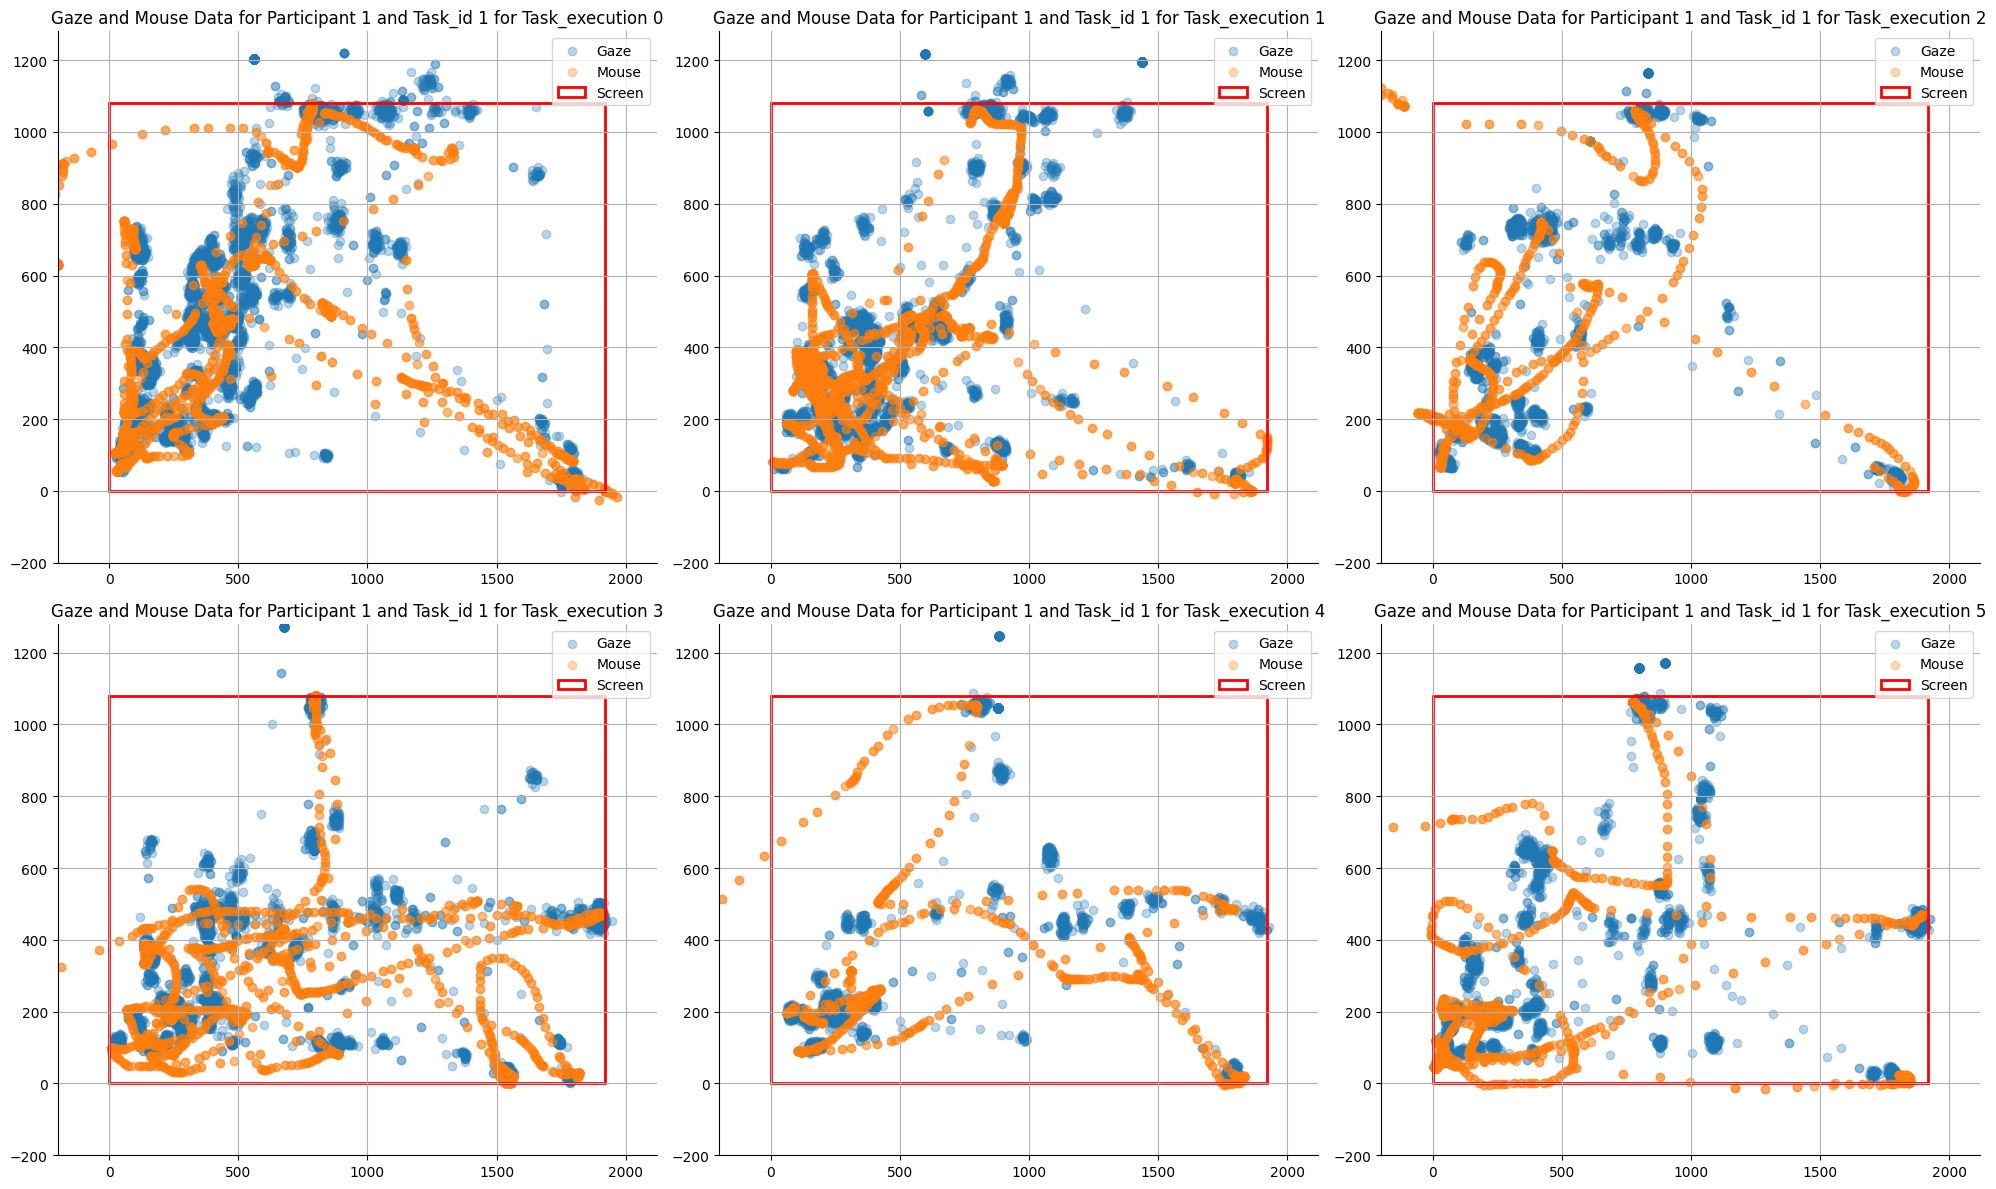

In [13]:
# Comparisons of the different gazes for one task for one participant

name = 1
task = 1

fig, axes = plt.subplots(2, 3, figsize=(20, 12)) 
axes = axes.flatten()
data_plot = dataset.query(f"`Participant name` == {name} and Task_id == {task}")
for i, period in enumerate(data_plot.Task_execution.unique().tolist()):
    axes[i].scatter(data_plot.query(f"Task_execution == {period}")["Gaze point X"], data_plot.query(f"Task_execution == {period}")["Gaze point Y"], label="Gaze", alpha=0.3)
    axes[i].scatter(data_plot.query(f"Task_execution == {period}")["Mouse position X"], data_plot.query(f"Task_execution == {period}")["Mouse position Y"], label="Mouse", alpha=0.3)
    axes[i].set_title(f"Gaze and Mouse Data for Participant {name} and Task_id {task} for Task_execution {period}")
    axes[i].add_patch(plt.Rectangle((0, 0), 1920, 1080, fill=None, color='r', linewidth=2, label="Screen"))
    axes[i].legend()
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].grid(True)
    axes[i].set_xlim(-200, 2120)
    axes[i].set_ylim(-200, 1280)

plt.tight_layout()
plt.show()

In [14]:
print(f"Proportion of gaze outside the screen: {np.round(len(dataset.query("`Gaze point X` < 0 or `Gaze point X` > 1920 or `Gaze point Y` < 0 or `Gaze point Y` > 1080"))/len(dataset),2)}")
print(f"Proportion of mouse outside the screen: {np.round(len(dataset.query("`Mouse position X` < 0 or `Mouse position X` > 1920 or `Mouse position Y` < 0 or `Mouse position Y` > 1080"))/len(dataset),2)}")

Proportion of gaze outside the screen: 0.11
Proportion of mouse outside the screen: 0.15


## Set mouse and gaze to nan if outside the screen (For now not applied)

In [ ]:
# Set values of gaze and mouse to Nan if they are outside the screen (+buffer layer of 200 pixels)
# alternative way, we can use the function clip() to set the values to the boundaries of the screen
# Maybe clip is better than Nans becose otherwise we have missing values for the whole columns in some chunks
# Having gaze outside the screen can also be interesting because it can be a sign of distraction

x_min, x_max = -200, 2120
y_min, y_max = -200, 1280 

dataset["Gaze point X"] = np.where(
    (dataset["Gaze point X"] < x_min) | (dataset["Gaze point X"] > x_max),
    np.nan, 
    dataset["Gaze point X"]
)

dataset["Gaze point Y"] = np.where(
    (dataset["Gaze point Y"] < y_min) | (dataset["Gaze point Y"] > y_max),
    np.nan, 
    dataset["Gaze point Y"]
)

dataset["Mouse position X"] = np.where(
    (dataset["Mouse position X"] < x_min) | (dataset["Mouse position X"] > x_max),
    np.nan, 
    dataset["Mouse position X"]
)

dataset["Mouse position Y"] = np.where(
    (dataset["Mouse position Y"] < y_min) | (dataset["Mouse position Y"] > y_max),
    np.nan, 
    dataset["Mouse position Y"]
)

dataset = dataset.reset_index(drop=True)

## Devide each task into chunks of 5s

In [15]:
# Define chunk size
chunk_size = 5 * 1e6
min_duration = 5 * 1e6

# Apply chunking for each unique combination of Participant, Task, and Period
dataset["chunk_id"] = np.nan  # Initialize column

for (participant, task, period), group in dataset.groupby(["Participant name", "Task_id", "Task_execution"]):
    start_time = group["Recording timestamp"].iloc[0]  # Get first timestamp of the group
    chunk_ids = (group["Recording timestamp"] - start_time) // chunk_size
    # Set the last chunk to NaN if it is too short
    if (group["Recording timestamp"].iloc[-1] - start_time) % chunk_size < min_duration:
        chunk_ids[chunk_ids == chunk_ids.max()] = np.nan
    dataset.loc[group.index, "chunk_id"] = chunk_ids

# Convert chunk_id to integer
dataset["chunk_id"] = dataset["chunk_id"].astype("Int64")

# Get the length of chunks for each combination
chunk_lengths = dataset.groupby(["Participant name", "Task_id", "Task_execution", "chunk_id"]).size()


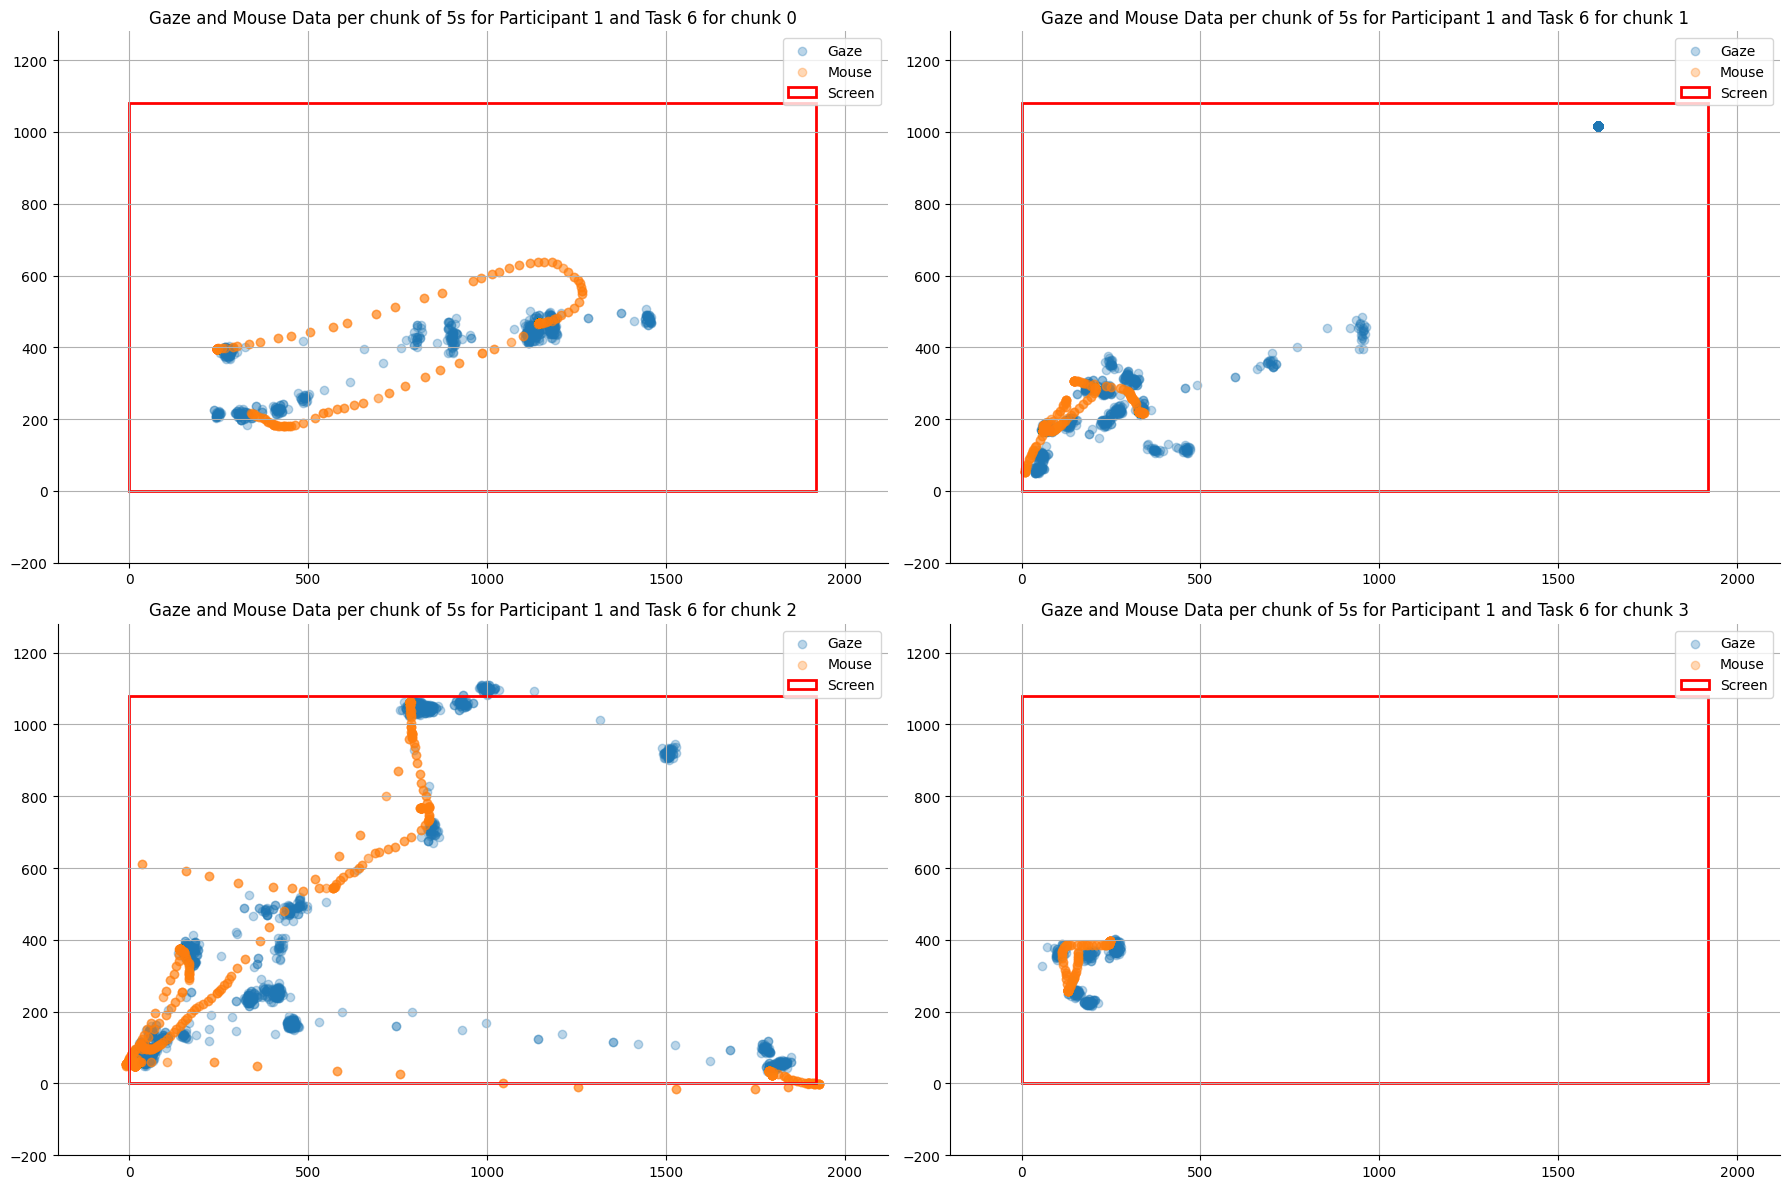

In [16]:
# Comparisons of the chunks for one task for one participant
participant = np.random.choice(dataset["Participant name"].unique())
task_id = np.random.choice(dataset["Task_id"].unique())
task_execution = np.random.choice(dataset["Task_execution"].unique())
data_plot = dataset.query(f"`Participant name` == {participant} and Task_id == {task_id} and Task_execution == {task_execution}")
nb_chunks = len(data_plot.chunk_id.dropna().unique())
nb_columns = 2
nb_rows = nb_chunks // nb_columns + (nb_chunks % nb_columns > 0)

fig, axes = plt.subplots(nb_rows, 2, figsize=(18, 12)) 
axes = axes.flatten()
for i in range(nb_chunks):
    axes[i].scatter(data_plot.query(f"chunk_id == {i}")["Gaze point X"], data_plot.query(f"chunk_id == {i}")["Gaze point Y"], label="Gaze", alpha=0.3)
    axes[i].scatter(data_plot.query(f"chunk_id == {i}")["Mouse position X"], data_plot.query(f"chunk_id == {i}")["Mouse position Y"], label="Mouse", alpha=0.3)
    axes[i].set_title(f"Gaze and Mouse Data per chunk of 5s for Participant {participant} and Task {task_id} for chunk {i}")
    axes[i].add_patch(plt.Rectangle((0, 0), 1920, 1080, fill=None, color='r', linewidth=2, label="Screen"))
    axes[i].legend()
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].grid(True)
    axes[i].set_xlim(-200, 2120)
    axes[i].set_ylim(-200, 1280)

plt.tight_layout()
plt.show()

## Interpolation so that each chunk has the same number of observations with constant time spacings

- The device recored the data at 120Hz, so 600 datapoints for 5 seconds.
- We resample the data to have 600 datapoints for each chunk
- We use linear interpolation to fill the resampled timestamps

In [17]:
participant = 4
task_id = 4
task_execution = 0

test = dataset.query(f"`Participant name` == {participant} and Task_id == {task_id} and Task_execution == {task_execution}")
for chunk in test["chunk_id"].dropna().unique():
    print(f"Chunk {chunk} duration: {round((test.query(f'chunk_id == {chunk}')['Recording timestamp'].iloc[-1] - test.query(f'chunk_id == {chunk}')['Recording timestamp'].iloc[0]) / 1e6, 2)} s")
    print(f"Chunk {chunk} length: {len(test.query(f'chunk_id == {chunk}'))}", end="\n\n")

Chunk 2 duration: 23.69 s
Chunk 2 length: 1575

Chunk 1 duration: 10.09 s
Chunk 1 length: 641

Chunk 0 duration: 4.02 s
Chunk 0 length: 601

Chunk 3 duration: 1.4 s
Chunk 3 length: 227



In [18]:
def resample_chunks(df, interpolate_col = ['Recording timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y'], chunk_col = "chunk_id", target_size = 600):
    resampled_dfs = []
    
    #chunk_id nan is not considered
    for chunk_id, sub_df in df.groupby(chunk_col):
        sub_df = sub_df.sort_index()

        original_indices = np.linspace(0, 1, len(sub_df)) 
        new_indices = np.linspace(0, 1, target_size)

        # Interpolate each column
        resampled_sub_df = pd.DataFrame(index=new_indices)
        for col in interpolate_col:
            if col != chunk_col:  # Skip the chunk_id column itself
                resampled_sub_df[col] = np.interp(new_indices, original_indices, sub_df[col])
        
        #Get rid of nans
        # resampled_sub_df = resampled_sub_df.ffill().bfill()
        #Check if come columns only have nans
        if resampled_sub_df.isna().all().any():
            print(f"Processing participant {sub_df['Participant name'].iloc[0]}, task {sub_df['Task_id'].iloc[0]}, execution {sub_df['Task_execution'].iloc[0]}, chunk {chunk_id}")
            print(resampled_sub_df.columns[resampled_sub_df.isna().all()].tolist(), end="\n\n")
        resampled_sub_df[chunk_col] = chunk_id
        resampled_dfs.append(resampled_sub_df)

    return pd.concat(resampled_dfs).reset_index(drop=True)

def process_and_resample_all(dataset, chunk_col='chunk_id', target_size=600):
    """Processes all unique (Participant name, Task_id, Task_execution) groups, resamples them, and combines into one dataset."""
    all_resampled_dfs = []
    unique_combinations = dataset[['Participant name', 'Task_id', 'Task_execution']].drop_duplicates()

    for _, row in unique_combinations.iterrows():
        participant, task_id, task_execution = row['Participant name'], row['Task_id'], row['Task_execution']
        subset = dataset.query(f"`Participant name` == {participant} and Task_id == {task_id} and Task_execution == {task_execution}")
        
        if len(subset) > 0:
            resampled_subset = resample_chunks(subset, chunk_col=chunk_col, target_size=target_size)
            resampled_subset['Participant name'] = participant
            resampled_subset['Task_id'] = task_id
            resampled_subset['Task_execution'] = task_execution

            all_resampled_dfs.append(resampled_subset)

    final_dataset = pd.concat(all_resampled_dfs).reset_index(drop=True)
    
    return final_dataset


resampled_dataset = process_and_resample_all(dataset, chunk_col='chunk_id', target_size=600)

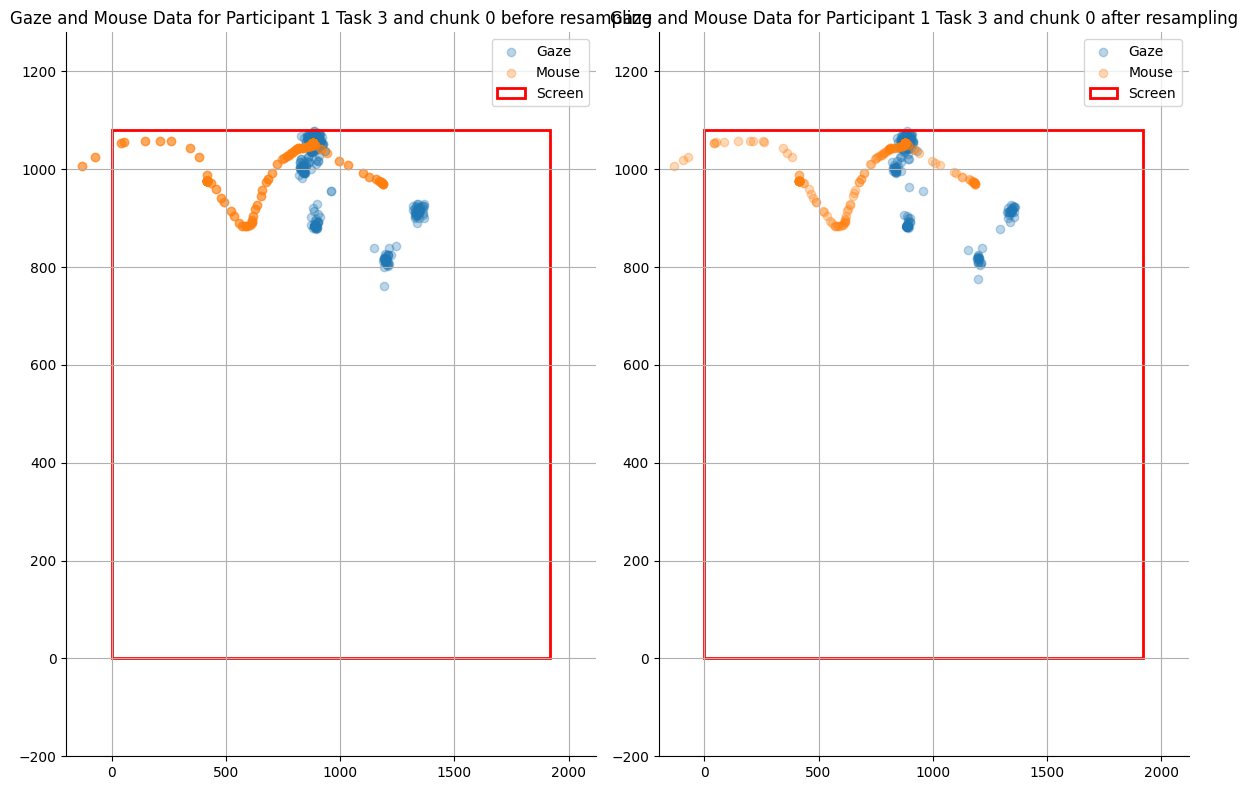

In [19]:
# Comparision of chunks before and after resampling
participant = np.random.choice(dataset["Participant name"].unique())
task_id = np.random.choice(dataset["Task_id"].unique())
task_execution = np.random.choice(dataset["Task_execution"].unique())
data_plot = dataset.query(f"`Participant name` == {participant} and Task_id == {task_id} and Task_execution == {task_execution}")
chunk_id = np.random.choice(data_plot["chunk_id"].dropna().unique())
data_plot_initial = data_plot.query(f"chunk_id == {chunk_id}")
data_plot_resampled = resampled_dataset.query(f"`Participant name` == {participant} and Task_id == {task_id} and Task_execution == {task_execution} and chunk_id == {chunk_id}")

fig, axes = plt.subplots(1, 2, figsize=(12, 8)) 
axes = axes.flatten()
axes[0].scatter(data_plot_initial["Gaze point X"], data_plot_initial["Gaze point Y"], label="Gaze", alpha=0.3)
axes[0].scatter(data_plot_initial["Mouse position X"], data_plot_initial["Mouse position Y"], label="Mouse", alpha=0.3)
axes[0].set_title(f"Gaze and Mouse Data for Participant {participant} Task {task_id} and chunk {chunk_id} before resampling")
axes[0].add_patch(plt.Rectangle((0, 0), 1920, 1080, fill=None, color='r', linewidth=2, label="Screen"))
axes[0].legend()
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].grid(True)
axes[0].set_xlim(-200, 2120)
axes[0].set_ylim(-200, 1280)

axes[1].scatter(data_plot_resampled["Gaze point X"], data_plot_resampled["Gaze point Y"], label="Gaze", alpha=0.3)
axes[1].scatter(data_plot_resampled["Mouse position X"], data_plot_resampled["Mouse position Y"], label="Mouse", alpha=0.3)
axes[1].set_title(f"Gaze and Mouse Data for Participant {participant} Task {task_id} and chunk {chunk_id} after resampling")
axes[1].add_patch(plt.Rectangle((0, 0), 1920, 1080, fill=None, color='r', linewidth=2, label="Screen"))
axes[1].legend()
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].grid(True)
axes[1].set_xlim(-200, 2120)
axes[1].set_ylim(-200, 1280)


plt.tight_layout()
plt.show()

### WARNINGS:
- X and Y values can be negatives for the gaze and the mouse. Are they outliers?
- The patterns seem quite different for a same task across the different participants. Are they well identified?
- I think it's interesting to add a marker of outside/inside the screen. Times when they are looking outside is interesting as well. Maybe put them to -1 just as the nans ?
- !!! Do the scaling only on the values that are useful: Nans or outside the screen should not be part of the scaling
- Explore unsupervised learning to classify chunks of time series 
- Instead of training of the full task, train on 10 seconds of observation and classify those 10 seconds with a task. 

****
# Training SVM
****

First idea:
- One sample is 600 observations, for one participant, one task, and one chunk_id
- Label is task_id
- First we will work on aggregated features like min/max/mean/std to see if they are sufficient to predict. If not we will use the full time series and train an LSTM of whatever. 
- Try using multi-head 2D CNN: one for gazeX/Y and another one for MouseX/Y

In [35]:
resampled_dataset

,Recording timestamp,Gaze point X,Gaze point Y,Mouse position X,Mouse position Y,chunk_id,Participant name,Task_id,Task_execution
0,2.094528e+08,816.000000,1054.000000,-181.000000,911.000000,0,1,1,0
1,2.094809e+08,806.000000,1060.796327,-181.000000,911.000000,0,1,1,0
2,2.095035e+08,796.000000,1067.000000,-181.734558,911.000000,0,1,1,0
3,2.095278e+08,794.000000,1061.000000,-181.898164,911.203673,0,1,1,0
4,2.095447e+08,792.000000,1054.000000,-174.901503,916.283806,0,1,1,0
...,...,...,...,...,...,...,...,...,...
363595,7.302138e+08,1763.000000,26.000000,1645.687813,82.008347,2,5,6,5
363596,7.302191e+08,1749.719533,21.439065,1658.000000,77.000000,2,5,6,5
363597,7.302280e+08,1747.000000,16.000000,1670.661102,71.460768,2,5,6,5
363598,7.302335e+08,1760.258765,20.186978,1690.000000,63.000000,2,5,6,5


In [87]:
def flatten_group(group):
    return np.concatenate([
        group['Gaze point X'].values,
        group['Gaze point Y'].values,
        group['Mouse position X'].values,
        group['Mouse position Y'].values
    ])

# Grouping by participant, task, execution, and chunk
grouped_data = resampled_dataset.groupby(['Participant name', 'Task_id', 'Task_execution', 'chunk_id']).apply(flatten_group)

# Flatten column names after aggregation
flattened_df = grouped_data.reset_index()
flattened_df.columns = ['Participant name', 'Task_id', 'Task_execution', 'chunk_id', 'flattened_features']

# Extract features (X) and labels (y)
X = np.vstack(flattened_df['flattened_features'].values)
y = flattened_df['Task_id'].values

# Train/test split (WARNING: split before if using time series data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


C:\Users\kruu\AppData\Local\Temp\ipykernel_22712\2566341278.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_data = resampled_dataset.groupby(['Participant name', 'Task_id', 'Task_execution', 'chunk_id']).apply(flatten_group)


In [ ]:
# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'linear']  # Kernel type
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
print(best_params)

# Train SVM
svm_model = SVC(kernel=best_params["kernel"], C=best_params["C"], gamma=best_params["gamma"])
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(classification_rep)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
0.3524590163934426
              precision    recall  f1-score   support

           1       0.35      0.45      0.39        20
           2       0.33      0.43      0.38        21
           3       0.26      0.36      0.30        14
           4       0.60      0.32      0.42        28
           5       0.22      0.22      0.22        18
           6       0.41      0.33      0.37        21

    accuracy                           0.35       122
   macro avg       0.36      0.35      0.35       122
weighted avg       0.39      0.35      0.36       122

